<a href="https://colab.research.google.com/github/ODENSUKI/glide-text2im/blob/main/GLIDE_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from typing import Tuple

from IPython.display import display
from PIL import Image
import numpy as np
import torch as th
import torch.nn.functional as F

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [4]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')
print(device)

cpu


In [5]:
# Create base model.
options = model_and_diffusion_defaults()
options['inpaint'] = True
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '500' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base-inpaint', device))
print(model.parameters())
print('total base parameters', sum(x.numel() for x in model.parameters()))

  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

<generator object Module.parameters at 0x7ff3a7875ad0>
total base parameters 385037638


In [6]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['inpaint'] = True
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample-inpaint', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

total upsampler parameters 398368198


In [22]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

def read_image(path: str, size: int = 256) -> Tuple[th.Tensor, th.Tensor]:
    pil_img = Image.open(path).convert('RGB')
    pil_img = pil_img.resize((size, size), resample=Image.BICUBIC)
    img = np.array(pil_img)
    return th.from_numpy(img)[None].permute(0, 3, 1, 2).float() / 127.5 - 1

def resize_image(path: str, size: int = 256): #画像をリサイズする
    pil_img_resize = Image.open(path).convert('RGB')
    pil_img_resize = pil_img_resize.resize((size, size), resample=Image.BICUBIC)
    pil_img_resize.save(path + '_resize.png')
    return print('Resize done.')

def read_mask(path: str) -> np.array: #マスク画像の読み込み
    mask_img = Image.open(path).convert('RGB')
    mask_img_np = np.array(mask_img)
    for x in range(len(mask_img_np)):
        for y in range(len(mask_img_np)):
            if all(mask_img_np[x, y] == [0, 0, 0]):
                mask_img_np[x, y] = [1]
            else:
                mask_img_np[x, y] = [0]
    return th.from_numpy(mask_img_np)[None].permute(0, 3, 1, 2).float()[:, :1] #shapeを[1,1,size,size]にするため


def save_images(data: th.Tensor, batch_size = batch_size): #画像の保存
    raw_data = ((data + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    for number in range(batch_size):
        save_numpy = raw_data[number].permute(1, 2, 0).numpy()
        Image.fromarray(save_numpy).save('./save_image/' + original_data + '_' + prompt + '_' + '{}.png'.format(number))
    print('All data saved!')

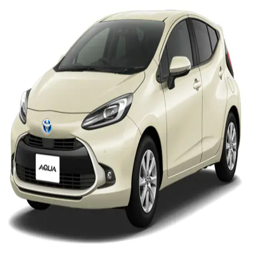

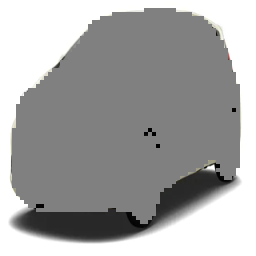

In [23]:
# Sampling parameters
prompt = "zebra stripe car"
batch_size = 9
guidance_scale = 1.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

#=========================================
original_data = 'aqua.png'
#=========================================

# Source image we are inpainting
source_image_256 = read_image(original_data, size=256)
source_image_64 = read_image(original_data, size=64)

# The mask should always be a boolean 64x64 mask, and then we
# can upsample it for the second stage.
source_mask_64 = read_mask(original_data + '_resize_mask.png')
source_mask_256 = F.interpolate(source_mask_64, (256, 256), mode='nearest')

# Visualize the image we are inpainting
show_images(source_image_256)
show_images(source_image_256 * source_mask_256)

In [ ]:
##############################
# Sample from the base model #
##############################

# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=th.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),

    # Masked inpainting image
    inpaint_image=(source_image_64 * source_mask_64).repeat(full_batch_size, 1, 1, 1).to(device),
    inpaint_mask=source_mask_64.repeat(full_batch_size, 1, 1, 1).to(device),
)

# Create an classifier-free guidance sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

def denoised_fn(x_start):
    # Force the model to have the exact right x_start predictions
    # for the part of the image which is known.
    return (
        x_start * (1 - model_kwargs['inpaint_mask'])
        + model_kwargs['inpaint_image'] * model_kwargs['inpaint_mask']
    )

# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
    denoised_fn=denoised_fn,
)[:batch_size]
model.del_cache()

# Show the output
show_images(samples)

  0%|          | 0/500 [00:00<?, ?it/s]